In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from researchlib.single_import import *

Using GPU 0: GeForce RTX 2080 Ti
Driver: 418.56


In [3]:
x = np.load('cat_face.npy')
x = (x * 2) - 1
train_loader = FromNumpy((x, x), 1, 64)

In [4]:
runner = Runner(GANModel(AutoGAN_G(), AutoGAN_D(), latent_vector_len=100),#, condition_vector_len=[10, 10], condition_onehot=True),
                train_loader, 
                None, 
                'adam_gan',
                GANLoss('relative'),
                monitor_state='g_loss',
                monitor_mode='min')

In [5]:
runner.init_model('default')

In [6]:
runner.fit(150)

Output()

In [19]:
runner.load_epoch(147)

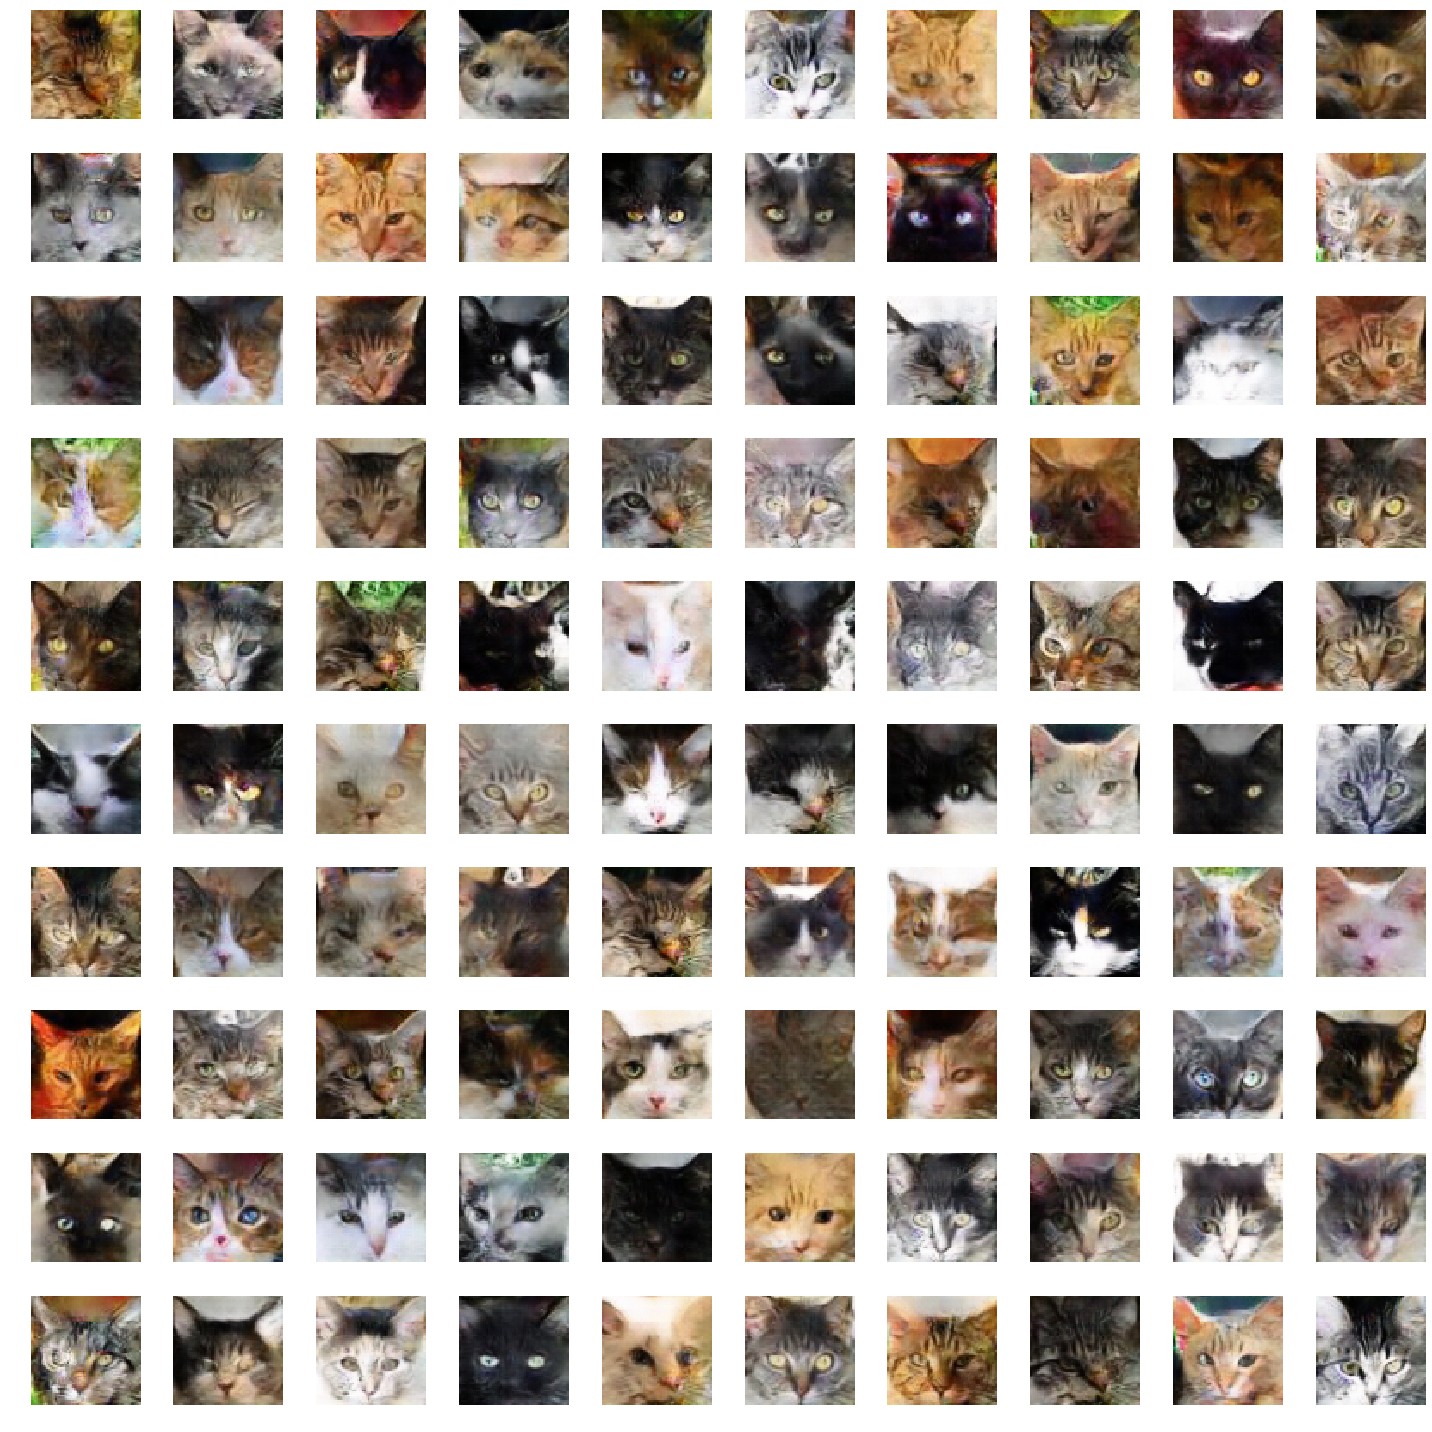

In [20]:
# img = runner.model.sample(100, condition_data=list(range(10))*10)
runner.model.cpu()
img = runner.model.sample(100)
img = (img+1)/2
import matplotlib.pyplot as plt
fig, arr = plt.subplots(10, 10, figsize=(20, 20))
for i in range(100):
    r = img[i].detach().cpu().numpy().transpose(1,2,0)
    arr[i//10][i%10].axis('off')
    arr[i//10][i%10].imshow(r)#, cmap='gray')
plt.tight_layout()
plt.show()

In [8]:
runner.report()

Experiment: default
Checkpoints are saved in ./checkpoint/default


Epoch,train_d_loss,train_g_loss,saved
1,0.301372,8.265923,*
2,0.203848,5.911133,*
3,0.230854,6.178515,
4,0.204692,5.543915,*
5,0.182938,6.535147,
6,0.173548,5.744243,
7,0.162395,6.518273,
8,0.152950,6.038888,
9,0.141297,6.425721,
10,0.122050,5.797441,
